In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from examples.RLC.symbolic_RLC import fxu_ODE, fxu_ODE_nl
from examples.RLC.loader import rlc_loader_multitask
from examples.RLC.jfr import JFRTester
from pathlib import Path

Dataset test/R:2.0005479452697545_L:5.963974503396337e-05_C:4.4174291934218044e-07.npy:   0%|          | 0/3 [00:00<?, ?it/s]

3


Dataset test/R:2.0005479452697545_L:5.963974503396337e-05_C:4.4174291934218044e-07.npy: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]
Dataset test/R:4.198512930894825_L:6.125137871802864e-05_C:7.699455426617554e-07.npy: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]
Dataset test/R:1.3653511125173492_L:0.00011632633135961731_C:2.8486052695566855e-07.npy: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


{'test/R:2.0005479452697545_L:5.963974503396337e-05_C:4.4174291934218044e-07.npy': {20: {'mse': {'adapted_model': 0.9206722378730774, 'pretrained_model': 0.1168925017118454}, 'rsquared': {'adapted_model': 0.11844485998153687, 'pretrained_model': 0.8880739808082581}}, 30: {'mse': {'adapted_model': 0.1649332344532013, 'pretrained_model': 0.12215845286846161}, 'rsquared': {'adapted_model': 0.8419312238693237, 'pretrained_model': 0.8829257488250732}}, 100: {'mse': {'adapted_model': 0.17226043343544006, 'pretrained_model': 0.11760704219341278}, 'rsquared': {'adapted_model': 0.8333853483200073, 'pretrained_model': 0.8862475156784058}}}, 'test/R:4.198512930894825_L:6.125137871802864e-05_C:7.699455426617554e-07.npy': {20: {'mse': {'adapted_model': 3.3714256286621094, 'pretrained_model': 0.2762396037578583}, 'rsquared': {'adapted_model': -2.4721853733062744, 'pretrained_model': 0.7155045866966248}}, 30: {'mse': {'adapted_model': 0.44521912932395935, 'pretrained_model': 0.27726587653160095}, 'rs

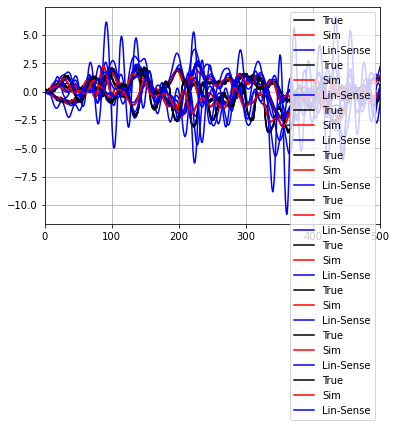

In [16]:
model_path = "/system/user/beck/pwbeck/meta/rnn-adaptation-multitask/models/ss_model.pt"
BASE_DIR = '/system/user/publicdata/meta_learning/ode/rlc_dataset-resistor_range1_14-capacitor_range100_800-inductor_range20_140'
datasets_dir = Path(BASE_DIR) / 'test'

support_sizes = [20, 30, 100]
jfr = JFRTester(model_path)
# jfr.pretrain() # TODO
eval_results = jfr.evaluate(base_dataset_dir=BASE_DIR, split='test', support_sizes=support_sizes, n_datasets=3)

In [17]:
eval_results[list(eval_results.keys())[0]]

{20: {'mse': {'adapted_model': 0.9206722378730774,
   'pretrained_model': 0.1168925017118454},
  'rsquared': {'adapted_model': 0.11844485998153687,
   'pretrained_model': 0.8880739808082581}},
 30: {'mse': {'adapted_model': 0.1649332344532013,
   'pretrained_model': 0.12215845286846161},
  'rsquared': {'adapted_model': 0.8419312238693237,
   'pretrained_model': 0.8829257488250732}},
 100: {'mse': {'adapted_model': 0.17226043343544006,
   'pretrained_model': 0.11760704219341278},
  'rsquared': {'adapted_model': 0.8333853483200073,
   'pretrained_model': 0.8862475156784058}}}

In [18]:
pd.DataFrame(eval_results).transpose()

,20,30,100
test/R:2.0005479452697545_L:5.963974503396337e-05_C:4.4174291934218044e-07.npy,"{'mse': {'adapted_model': 0.9206722378730774, ...","{'mse': {'adapted_model': 0.1649332344532013, ...","{'mse': {'adapted_model': 0.17226043343544006,..."
test/R:4.198512930894825_L:6.125137871802864e-05_C:7.699455426617554e-07.npy,"{'mse': {'adapted_model': 3.3714256286621094, ...","{'mse': {'adapted_model': 0.44521912932395935,...","{'mse': {'adapted_model': 0.2194971889257431, ..."
test/R:1.3653511125173492_L:0.00011632633135961731_C:2.8486052695566855e-07.npy,"{'mse': {'adapted_model': 0.8044513463973999, ...","{'mse': {'adapted_model': 1.5508806705474854, ...","{'mse': {'adapted_model': 2.308825731277466, '..."


In [44]:
adapt_result = eval_results[list(eval_results.keys())[1]][20]
adapt_result
pd.Series(adapt_result['mse']).index

Index(['adapted_model', 'pretrained_model'], dtype='object')

In [49]:
from typing import Dict, Any
import copy
def eval_results_to_df(eval_results: Dict[str, Dict[int, Dict]], metric='mse'):
    results = {}
    model_type_index = None
    for ds_name, ds_res in eval_results.items():
        results[ds_name] = {(support_size, mt): ds_ss_res[metric][mt] for support_size, ds_ss_res in ds_res.items() for mt in ds_ss_res[metric]} 
    
    multi_ind = pd.MultiIndex.from_tuples(results[ds_name].keys(), names=['support_size', 'model_type'])
    return pd.DataFrame(results, index=multi_ind).transpose()

In [54]:
df = eval_results_to_df(eval_results, metric='mse')
df

support_size                                                 20   \
modelt_type                                        adapted_model   
test/R:2.0005479452697545_L:5.963974503396337e-...      0.920672   
test/R:4.198512930894825_L:6.125137871802864e-0...      3.371426   
test/R:1.3653511125173492_L:0.00011632633135961...      0.804451   

support_size                                                         \
modelt_type                                        pretrained_model   
test/R:2.0005479452697545_L:5.963974503396337e-...         0.116893   
test/R:4.198512930894825_L:6.125137871802864e-0...         0.276240   
test/R:1.3653511125173492_L:0.00011632633135961...         0.595136   

support_size                                                 30   \
modelt_type                                        adapted_model   
test/R:2.0005479452697545_L:5.963974503396337e-...      0.164933   
test/R:4.198512930894825_L:6.125137871802864e-0...      0.445219   
test/R:1.3653511125173492_L:0.00011632633135961...      1.550881   

support_size                                                         \
modelt_type                                        pretrained_model   
test/R:2.0005479452697545_L:5.963974503396337e-...         0.122158   
test/R:4.198512930894825_L:6.125137871802864e-0...         0.277266   
test/R:1.3653511125173492_L:0.00011632633135961...         0.590325   

support_size                                                 100  \
modelt_type                                        adapted_model   
test/R:2.0005479452697545_L:5.963974503396337e-...      0.172260   
test/R:4.198512930894825_L:6.125137871802864e-0...      0.219497   
test/R:1.3653511125173492_L:0.00011632633135961...      2.308826   

support_size                                                         
modelt_type                                        pretrained_model  
test/R:2.0005479452697545_L:5.963974503396337e-...         0.117607  
test/R:4.198512930894825_L:6.125137871802864e-0...         0.273793  
test/R:1.3653511125173492_L:0.00011632633135961...         0.588997

In [56]:
df.to_csv(Path.cwd()/'results.csv')

In [57]:
df2 = pd.read_csv("/system/user/beck/pwbeck/meta/rnn-adaptation-multitask/notebooks/results.csv")

In [58]:
df2

,support_size,20,20.1,30,30.1,100,100.1
0,modelt_type,adapted_model,pretrained_model,adapted_model,pretrained_model,adapted_model,pretrained_model
1,test/R:2.0005479452697545_L:5.963974503396337e...,0.9206722378730774,0.1168925017118454,0.1649332344532013,0.12215845286846161,0.17226043343544006,0.11760704219341278
2,test/R:4.198512930894825_L:6.125137871802864e-...,3.3714256286621094,0.2762396037578583,0.44521912932395935,0.27726587653160095,0.2194971889257431,0.2737928330898285
3,test/R:1.3653511125173492_L:0.0001163263313596...,0.8044513463973999,0.5951362252235413,1.5508806705474854,0.5903251767158508,2.308825731277466,0.5889974236488342


In [2]:
Path('train/R:3.0_L:5e-05_C:2.7e-07.npy').stem

'R:3.0_L:5e-05_C:2.7e-07'